# 6.2 Edmonton AC Loads: Multi-Model Analysis

This notebook continues the workflow example about AC loads in the city of Edmonton, using a single ECCC station site as the spatial domain. Here we expand that example by including multiple CMIP6 models in the analysis. This allows us to characterize the uncertainty in our future projections due to uncertainty in modeling choices. We'll use one ensemble member each from the models listed below, chosen because they have data available on Google Cloud for the ensemble member `r4i1p1f1` (chosen because this `member_id` was used for many `ssp370` runs) and both the `historical` and `ssp370` scenarios. From each modeling centre, only one model is chosen (e.g. we don't include both `EC-Earth3` and `EC-Earth3-AerChem` from the `EC-Earth-Consortium` institution).

Models:
* AWI-CM-1-1-MR
* CESM2
* CanESM5
* EC-Earth3
* FGOALS-g3
* INM-CM5-0
* IPSL-CM6A-LR
* MPI-ESM1-2-LR
* MRI-ESM2-0

The [guided survey](https://utcdw.physics.utoronto.ca/survey/) on the main UTCDW website allows users to clone a survey, in order to change your response to one or more questions. To generate the flowchart below, I cloned the survey that generated the flowchart shown in 6.1, and changed the answer to the model data question from "CESM2" to "CMIP6 Multi-Model Ensemble", along with the title.

```{image} ./figures/survey_station_multimodel.png
:width: 600px
:align: center
```

## 6.2.1 Multi-Model Analysis

In the hidden code cells below, we'll re-access the same station data as we did in the previous section. Then we'll search the data catalog to get the download URLs for these model simulations, access the data, sub-select the data to our desired location and time periods, and then combine it all together using the `xclim.ensembles` framework. 

In [1]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indices as xci
import xclim.ensembles as xce
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import ec3
import gcsfs
import zarr
import os

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2070, 2101)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:218: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:238: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

In [2]:
# get the same station data as from 6.1

def download_station_data(stn_id, years = range(1992, 2022)):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'time', 
                        'Mean Temp (°C)': 'tas',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only the variables we re-named - you can comment this out if you want to keep all variables
    df = df[list(column_name_dict.values())]
    
    # set the "time" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    df = df.dropna()
    
    return df

In [3]:
# download the station data
stn_id_list = [1867, 31427]
df_list = []
for stn_id in stn_id_list:
    df = download_station_data(stn_id, years = years_hist)
    df_list.append(df)
    
stn_df = pd.concat(df_list, axis = 0)

# now convert it to xarray format for easier use with the model data and xclim

# drop lat and lon variables, since we want these to be coordinates in the xr.Dataset
stn_lon = stn_df.lon.values[0] + 360 # convert lon to same convention as model data
stn_lat = stn_df.lat.values[0] 

stn_df = stn_df.drop(['lat', 'lon'], axis = 1)

stn_ds = xr.Dataset.from_dataframe(stn_df)
stn_ds = stn_ds.assign_coords(lat = stn_lat, lon = stn_lon)

stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas

In [4]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for models which have daily tas data from the historical and SSP3-3.0 scenarios
search_string_mm = "table_id == 'day' & variable_id == 'tas' & member_id == 'r4i1p1f1'" # continue on the next line
search_string_mm += " & experiment_id == ['historical', 'ssp370']"
df_search_mm = df_catalog.query(search_string_mm).sort_values('source_id')
df_search_mm

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
447474,CMIP,CSIRO,ACCESS-ESM1-5,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/hist...,NaN,20200529
45526,CMIP,AWI,AWI-CM-1-1-MR,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
203937,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
61604,CMIP,NCAR,CESM2,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
446493,ScenarioMIP,NCAR,CESM2,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370...,NaN,20200528
91510,CMIP,CCCma,CanESM5,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
108616,ScenarioMIP,CCCma,CanESM5,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
439125,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r4i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200425
438347,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp370,r4i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200425
501363,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r4i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20201214


In [5]:
# refine the list to include only the chosen models
models = ['AWI-CM-1-1-MR', 'CESM2', 'CanESM5', 'EC-Earth3', 
          'FGOALS-g3','INM-CM5-0', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']
df_search_mm = df_search_mm.query(f"source_id == {models}")
df_search_mm

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
45526,CMIP,AWI,AWI-CM-1-1-MR,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
203937,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,NaN,20190529
61604,CMIP,NCAR,CESM2,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
446493,ScenarioMIP,NCAR,CESM2,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370...,NaN,20200528
91510,CMIP,CCCma,CanESM5,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
108616,ScenarioMIP,CCCma,CanESM5,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
439125,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r4i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200425
438347,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp370,r4i1p1f1,day,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20200425
395178,ScenarioMIP,CAS,FGOALS-g3,ssp370,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp...,NaN,20191212
376691,CMIP,CAS,FGOALS-g3,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/historical...,NaN,20191030


In [6]:
# function for pre-processing data
def get_and_process_data(catalog_df, model, scenario, gcs, lat, lon, years):
    # get the ztore url for this model and scenario
    df_scen = catalog_df.query(f"source_id == '{model}' & experiment_id == '{scenario}'")
    zstore_url = df_scen.zstore.values[0]
    
    # get the GCS mapper from the url
    mapper = gcs.get_mapper(zstore_url)
    
    # open the file with xarray
    ds = xr.open_zarr(mapper, consolidated = True)
    
    # get the tas data, select the time period, and interp to the desired location
    tas_loc = ds.tas.sel(time = ds.time.dt.year.isin(years)).interp(lat = lat, lon = lon)
    
    # drop 'height' coordinate, which is always 2m but isn't present on all datasets
    if 'height' in tas_loc.coords.keys():
        tas_loc = tas_loc.reset_coords('height', drop = True)
        
    # some datasets put the date at 12:00 whereas some put it at 00:00. To make all
    # of them consistent, simply change the time coordinate to the date only
    tas_loc = tas_loc.assign_coords(time = tas_loc.time.dt.floor('D'))
    # convert from Kelvin to Celsius and return
    
    tas_loc = tas_loc - 273.15
    return tas_loc.compute()

In [7]:
# function for downloading the data
def download_data_multimodel(catalog_df, gcs, models, scenario,
                             stn_lat, stn_lon,
                             years_hist, years_future):

    ds_list_hist = []
    ds_list_future = []
    for model in models:
        print(f"========================{model}=============================")
        print('historical')
        tas_model_hist = get_and_process_data(catalog_df, model, 'historical', 
                                              gcs, stn_lat, stn_lon, years_hist)
        ds_list_hist.append(tas_model_hist)
    
        # get the future simulation data for this model and scenario
        print(scenario)
        tas_model_future = get_and_process_data(catalog_df, model, scenario, 
                                                gcs, stn_lat, stn_lon, years_future)
        ds_list_future.append(tas_model_future)

    print('finished acquiring model data')
    
    # concatenate the ds_lists together
    ds_ens_hist_raw = xce.create_ensemble(ds_list_hist,                             
                                          realizations = models,
                                          calendar = 'noleap') # common calendar to place all models onto

    ds_ens_future_raw = xce.create_ensemble(ds_list_future, 
                          # names of each model, which is represented by a dimension called 'realization'
                                           realizations = models,
                                           calendar = 'noleap')

    
    # return
    return ds_ens_hist_raw, ds_ens_future_raw

In [8]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# file names to save the downloaded data, to save time later when re-running this notebook
fout_hist = 'data_files/tas.cmip6.daily.historical.r4i1p1f1.1980-2010.edmonton.nc'
fout_future = 'data_files/tas.cmip6.daily.ssp3.r4i1p1f1.2070-2100.edmonton.nc'

# use the function to download the data, this may take a few minutes to run
if (not os.path.exists(fout_hist)) or (not os.path.exists(fout_future)):
    ds_ens_hist_raw, ds_ens_ssp3_raw = download_data_multimodel(df_search_mm, gcs, models, "ssp370",
                                                                  stn_lat, stn_lon, years_hist, years_future)

    # write the data to output files 
    ds_ens_hist_raw.to_netcdf(fout_hist)
    ds_ens_ssp3_raw.to_netcdf(fout_future)
else:
    # open the files that already exist
    ds_ens_hist_raw = xr.open_dataset(fout_hist)
    ds_ens_ssp3_raw = xr.open_dataset(fout_future)

## 6.2.2 Exploratory Multi-Model Analysis

```{warning}
Whether it's calculating a climate indicator from model output, or doing downscaling/bias correction, calculating ensemble statistics (across different models or different realizations of the same model) like a mean or standard deviation should be done as the **last step** before plotting or interpreting the results.

Calculating an ensemble mean too early in an analysis attenuates variability, and can artificially alter the model projections. Since different realizations of the same date across different ensemble members are unrelated, a given date (e.g., June 4th 2037, as an example) might exceed the CDD temperature threshold in some ensemble members, but not the others. The ensemble mean for that date (which isn't a meaningful quantity) might fall below the threshold, so that day would contribute zero to the total CDDs for that year. If one did the CDD calculation first and *then* calculated the ensemble mean, you'd get a larger number, which more faithfully reflects what the model is projecting.
```

With this multi-model ensemble, we can re-do all of the same steps as before with the single model. First, let's plot the daily climatologies of `tas` for each model, and compare to the observations. To make the plot more legible, we'll plot shading for only the observed one-$\sigma$ range. We can calculate the daily climatology for all models with a single line of code:

In [9]:
# calculate daily climatologies for the multi-model ensemble
tas_clim_mm_hist_raw = ds_ens_hist_raw.tas.groupby('time.dayofyear').mean('time').compute()

# same for observations
tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()

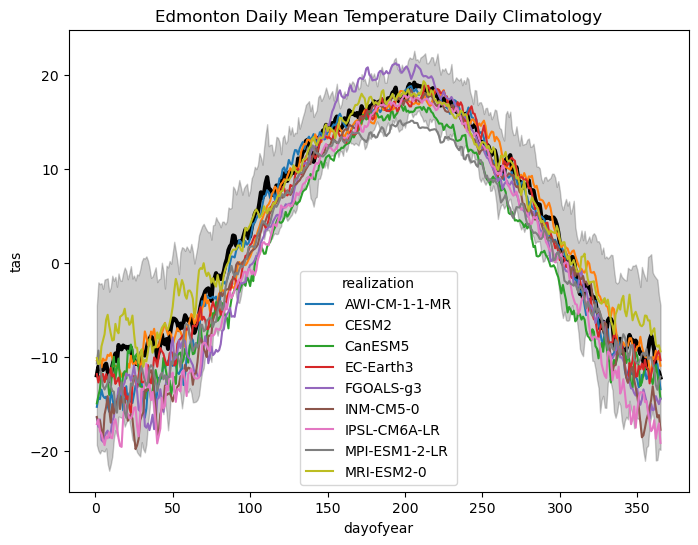

In [10]:
# plot the daily climatologies for all models
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
tas_clim_mm_hist_raw.plot.line(ax = ax, hue = 'realization')

# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'k')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
plt.show()

This plot is quite illustrative of the variations across models. Like the observed internal variability, there is also more variation across models in the winter season. There is also a range of biases across the different models, with some having means that fall near the low end of the normal observed range (like MPI-ESM1-2-LR) and others that peak at the high end of the observed range (like FGOALS-g3). These models will likely produce very different CDDs than the observations or from the first model we looked at, CESM2. Let's do the CDD calculation for each model using the raw data.

In [11]:
# assign unit to temperature data
tas_ens_hist_raw = ds_ens_hist_raw.tas
tas_ens_hist_raw.attrs['units'] = 'degC'
tas_obs_noleap.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs =  xci.cooling_degree_days(tas_obs_noleap).compute()
cdds_mm_hist_raw = xci.cooling_degree_days(tas_ens_hist_raw).compute()

# long-term means and stdevs
cdds_mm_hist_raw_ltm = cdds_mm_hist_raw.mean('time')
cdds_mm_hist_raw_stdev = cdds_mm_hist_raw.std('time')

cdd_obs_ltm = cdd_obs.mean('time')
cdd_obs_stdev = cdd_obs.std('time')

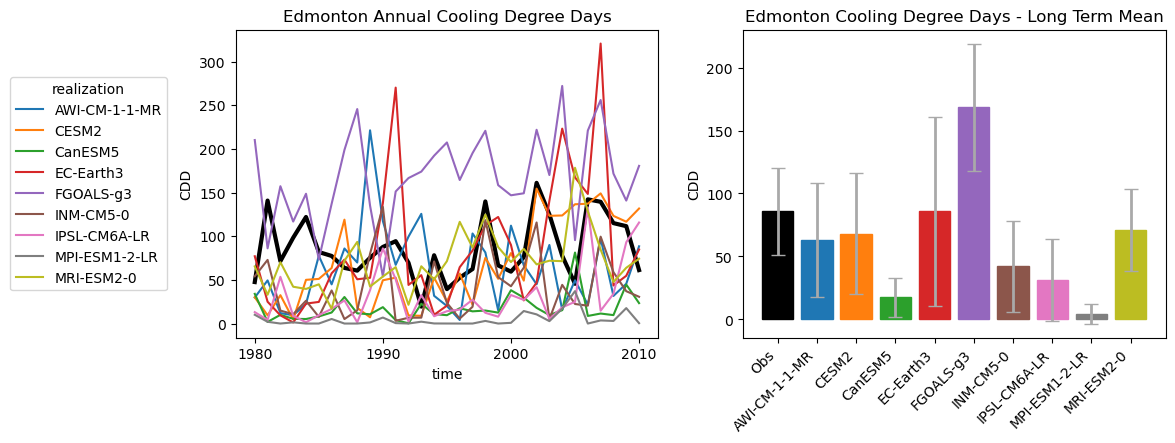

In [12]:
# plot timeseries of CDDs for multi-model historical ensemble and obs
fig, axes = plt.subplots(ncols = 2, figsize = (12, 4))
cdd_obs.plot.line(ax = axes[0], color = 'k', linewidth = 3)
lines = cdds_mm_hist_raw.plot.line(ax = axes[0], hue = 'realization')
# set legent location
sns.move_legend(axes[0], loc='center left', bbox_to_anchor=(-0.55, 0.5))
axes[0].set_title("Edmonton Annual Cooling Degree Days")

# plot long-term means
bars = axes[1].bar(['Obs'] + models, np.append(cdd_obs_ltm.values, cdds_mm_hist_raw_ltm.values),
                  yerr = np.append(cdd_obs_stdev.values, cdds_mm_hist_raw_stdev.values), 
                  capsize = 5, error_kw = {'ecolor': 'darkgrey', 'elinewidth': 2})

axes[1].set_title("Edmonton Cooling Degree Days - Long Term Mean")

# rotate the model labels so they're legible
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation = 45, ha = 'right')

# match bar colors to line colors
bars[0].set_color('k')
for i, b in enumerate(bars[1:]):
    b.set_color(lines[i].get_color())
     
for ax in axes:
    ax.set(ylabel = "CDD")

plt.show()

The inter-model variance in temperature has resulted in major variations in CDDs. The model with the coldest summer temperatures (MPI-ESM1-2-LR) has single-digit CDDs on average, while FGOALS-g3 exceeds 160 per year. This is an enormous range of biases, so for many of these models the bias correction should have a larger effect than it did for CESM2. Before doing the bias correction, let's examine the future projections from the raw model data. First the change in daily climatologies, then the CDDs.

In [13]:
# calculate daily climatologies for the multi-model ensemble, SSP3-7.0 end-of-century
tas_clim_mm_ssp3_raw = ds_ens_ssp3_raw.tas.groupby('time.dayofyear').mean('time').compute()

# climate change signal for daily clim
tas_clim_mm_delta_raw = tas_clim_mm_ssp3_raw - tas_clim_mm_hist_raw

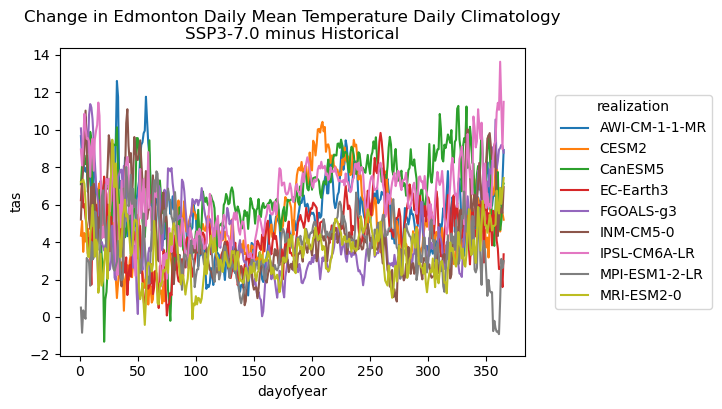

In [14]:
# plot the daily climatologies for all models
fig, ax = plt.subplots(figsize = (6,4))

# daily climatologies as 1D curves
# historical
tas_clim_mm_delta_raw.plot.line(ax = ax, hue = 'realization')

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5))

ax.set_title("Change in Edmonton Daily Mean Temperature Daily Climatology\nSSP3-7.0 minus Historical")
plt.show()

There is also a notable amount of model spread in the projections of future daily mean temperatures in Edmonton, especially in the winter season. The mean changes of up to 10 degrees for certain changes might have a big impact on the number of CDDs, since this can extend the warm season and thus the number of days that exceed the temperature threshold. Interestingly, CESM2 shows the greatest peak warming in the summer season, so the projections for that model may be on the high end of the multi-model range. To invesitage, let's plot the mean changes in the number of CDDs for each model.

In [15]:
# calculate CDDs for future period
tas_ens_ssp3_raw = ds_ens_ssp3_raw.tas
tas_ens_ssp3_raw.attrs['units'] = 'degC'

cdds_mm_ssp3_raw = xci.cooling_degree_days(tas_ens_ssp3_raw).compute()

# long-term means
cdds_mm_ssp3_raw_ltm = cdds_mm_ssp3_raw.mean('time')

# climate change deltas
cdds_mm_ssp3_raw_delta = cdds_mm_ssp3_raw_ltm - cdds_mm_hist_raw_ltm

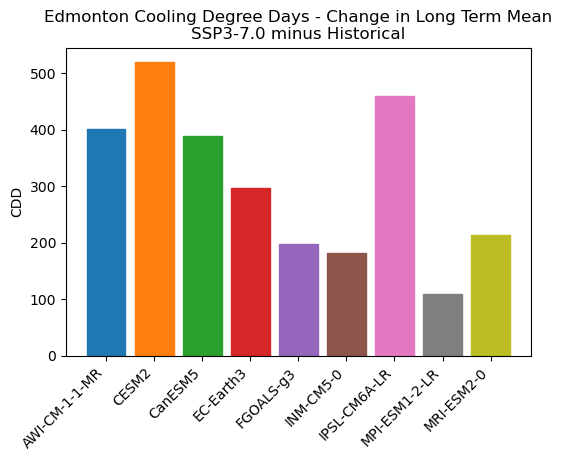

In [16]:
# plot deltas to CDDs
fig, ax = plt.subplots( figsize = (6, 4))
# plot long-term means
bars = ax.bar(models, cdds_mm_ssp3_raw_delta.values)
ax.set_title("Edmonton Cooling Degree Days - Change in Long Term Mean\nSSP3-7.0 minus Historical")

# rotate the model labels so they're legible
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 45, ha = 'right')

# match bar colors to line colors
for i, b in enumerate(bars):
    b.set_color(lines[i].get_color())
     
ax.set_ylabel('CDD')

plt.show()

Indeed CESM2 is the model that projects the largest increase to CDDs in its raw output, though it is not alone as an outlier. Interestingly the MPI model, which has the fewest historical CDDs, also projects the smallest increase. It's possible that this model's cold bias means that even after a similar amount of warming to other models, the baseline is so low that not many days exceed the temperature threshold by a large amount. We'll keep this model in mind when looking at the bias-corrected projections. 

## 6.2.3 Multi-Model Bias-Correction
Applying the bias correction is the next step in the multi-model workflow. Doing so is no more complicated than it was for the single model case, because the `xclim` routines automatically apply the correction separately over each dimension in the input dataset. Using multiple models is no different from using data with mutiple spatial dimensions, the `realization` is just another dimension to the data which has no effect on the calculations.

In [17]:
# fix the time axis chunking so xclim won't complain
tas_ens_hist_raw = tas_ens_hist_raw.chunk({'time': -1})
tas_ens_ssp3_raw = tas_ens_ssp3_raw.chunk({'time': -1})

In [18]:
# train and then apply the QDM bias correction
QDM_trained_mm = sdba.adjustment.QuantileDeltaMapping.train(tas_obs_noleap,     
                                                            tas_ens_hist_raw, 
                                                            nquantiles = 50, 
                                                            kind = "+",
                                                            group = 'time.month' 
                                                            )


tas_ens_hist_qdm = QDM_trained_mm.adjust(tas_ens_hist_raw,                              
                                         interp = 'linear')

tas_ens_ssp3_qdm = QDM_trained_mm.adjust(tas_ens_ssp3_raw,                                 
                                         interp = 'linear')

## 6.2.4 Validating the Multi-Model BC'd Data

Like before, we'll plot the historical cliamtologies using the downscaled data.

In [19]:
# calculate daily climatologies for the multi-model ensemble
tas_clim_mm_hist_qdm = tas_ens_hist_qdm.groupby('time.dayofyear').mean('time').compute()

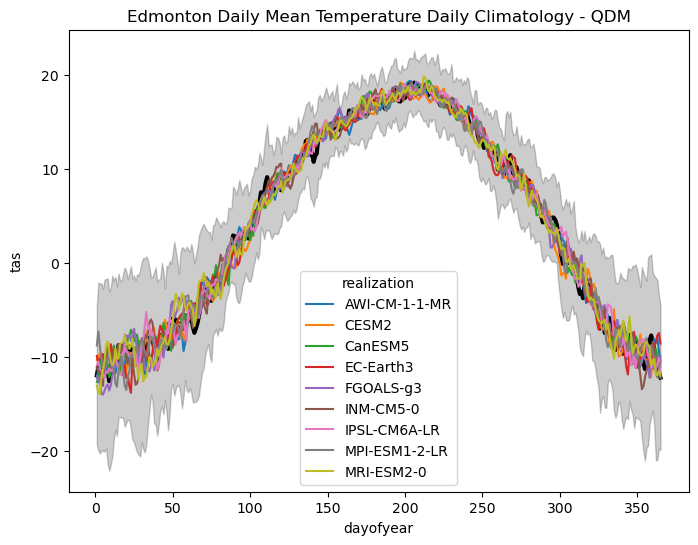

In [20]:
# plot the daily climatologies for all models, QDM
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
# obs
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'k', linewidth = 3)

# models
tas_clim_mm_hist_qdm.plot.line(ax = ax, hue = 'realization')

# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'k')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology - QDM")
ax.set_ylabel('tas')
plt.show()

As expected, the bias-adjusted historical data matches the observed seasonal cycle very well, with much less spread than the raw model simulations. Next we'll plot the historical CDDs.

In [21]:
# assign unit to temperature data
tas_ens_hist_qdm.attrs['units'] = 'degC'

# calculate CDDs
cdds_mm_hist_qdm = xci.cooling_degree_days(tas_ens_hist_qdm).compute()

# long-term means
cdds_mm_hist_qdm_ltm = cdds_mm_hist_qdm.mean('time')
cdds_mm_hist_qdm_stdev = cdds_mm_hist_qdm.std('time')

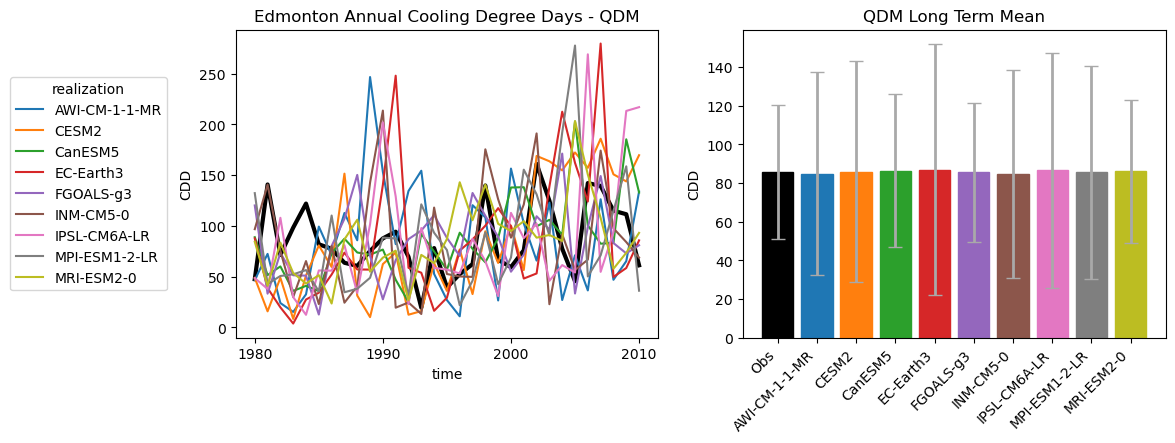

In [22]:
# plot timeseries of CDDs for bias-corrected multi-model historical ensemble and obs
fig, axes = plt.subplots(ncols = 2, figsize = (12, 4))
cdd_obs.plot.line(ax = axes[0], color = 'k', linewidth = 3)
lines = cdds_mm_hist_qdm.plot.line(ax = axes[0], hue = 'realization')
# set legent location
sns.move_legend(axes[0], loc='center left', bbox_to_anchor=(-0.55, 0.5))
axes[0].set_title("Edmonton Annual Cooling Degree Days - QDM")

# plot long-term means
bars = axes[1].bar(['Obs'] + models, np.append(cdd_obs_ltm.values, cdds_mm_hist_qdm_ltm.values),
                   yerr = np.append(cdd_obs_stdev.values, cdds_mm_hist_qdm_stdev.values), 
                   capsize = 5, error_kw = {'ecolor': 'darkgrey', 'elinewidth': 2})
axes[1].set_title("QDM Long Term Mean")


# rotate the model labels so they're legible
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation = 45, ha = 'right')

# match bar colors to line colors
bars[0].set_color('k')
for i, b in enumerate(bars[1:]):
    b.set_color(lines[i].get_color())
     
for ax in axes:
    ax.set(ylabel = "CDD")

plt.show()

Also as expected, the long-term means of the bias-corrected historical CDDs are also basically indistinguishable from the observations, though the ranges of variability differ slightly. 

## 6.2.5 Downscaled Climate Indicator
What impact has the bias correction had on the future projections? Let's take a look.

In [23]:
# calculate CDDs for future period
tas_ens_ssp3_qdm.attrs['units'] = 'degC'

cdds_mm_ssp3_qdm = xci.cooling_degree_days(tas_ens_ssp3_qdm).compute()

# long-term means
cdds_mm_ssp3_qdm_ltm = cdds_mm_ssp3_qdm.mean('time')

# climate change deltas
cdds_mm_ssp3_qdm_delta = cdds_mm_ssp3_qdm_ltm - cdds_mm_hist_qdm_ltm

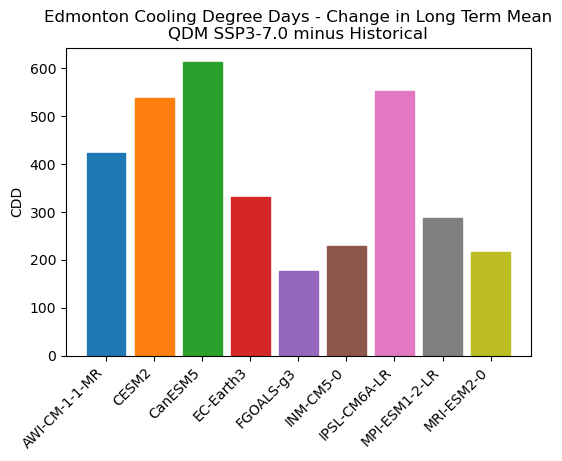

In [24]:
# plot deltas to CDDs - QDM
fig, ax = plt.subplots( figsize = (6, 4))
# plot long-term means
bars = ax.bar(models, cdds_mm_ssp3_qdm_delta.values)
ax.set_title("Edmonton Cooling Degree Days - Change in Long Term Mean\nQDM SSP3-7.0 minus Historical")

# rotate the model labels so they're legible
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 45, ha = 'right')

# match bar colors to line colors
for i, b in enumerate(bars):
    b.set_color(lines[i].get_color())
     
ax.set_ylabel('CDD')

plt.show()

After bias correction there is still a fairly sizeable range of projections across the different models, but the ordering has changed. Notably, the MPI model no longer projects the lowest increase, likely because the bias correction led to more days meeting the 18$^{\circ}$C threshold. CanESM5 now projects the largest increase instead of CESM2, though it had the third largest increase amongst the raw model data so the overall grouping hasn't changed by much. Using this multi-model ensemble of projections, we can create a likely range of projected changes for our future period (2070-2100) under the SSP3-7.0 scenario. We'll use the 10$^{\text{th}}$-90$^{\text{th}}$ percentile range of the inter-model spread as our range of projections.

In [25]:
cdd_change_10p = cdds_mm_ssp3_qdm_delta.quantile(0.1, dim = 'realization')
cdd_change_90p = cdds_mm_ssp3_qdm_delta.quantile(0.9, dim = 'realization')

result_str = "Likely Range of Mean CDD Change from 1980-2010 to 2070-2100 under SSP3-7.0: "
result_str += f"{np.around(cdd_change_10p.values, 1)} to {np.around(cdd_change_90p.values, 1)} CDD/year"

print(result_str)

Likely Range of Mean CDD Change from 1980-2010 to 2070-2100 under SSP3-7.0: 208.8 to 564.7 CDD/year


Or, in terms of percent changes, which may be easier to interpret:

In [26]:
# multi-model mean historical CDDs
cdds_hist_qdm_ltm_mm_mean = cdds_mm_hist_qdm_ltm.mean('realization')

result_str = "Likely Range of Mean CDD Change from 1980-2010 to 2070-2100 under SSP3-7.0: "
result_str += f"{int(np.around(100 * cdd_change_10p.values/cdds_hist_qdm_ltm_mm_mean.values, 0))}% to "
result_str +=f"{int(np.around(100 * cdd_change_90p.values/cdds_hist_qdm_ltm_mm_mean.values, 0))}%"

print(result_str)

Likely Range of Mean CDD Change from 1980-2010 to 2070-2100 under SSP3-7.0: 243% to 658%


This likely range of increases under this scenario is quite large, indicating that model structural uncertainty is very important to consider when studying changes to CDDs under climate change. Of course, there is also uncertainty relating to the future emissions scenario and internal climate variability. In the next section, we'll quantify the effect of scenario uncertainty on the future projections by considering multiple SSP scenarios.